In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score

file_path = 'chd_addmit_1500.xlsx'

columns_list = ['sex',
                 'height',
                 'weight',
                 'BMI',
                 'BSA',
                 'Операции (все в ИБ)',
                 'Перенесенные опер. (из Анамн.)',
                 'Диагноз',
                 'МКБ',
                 'Соп. забол. (из Анамн.)',
                 'Медикам. леч. по поводу осн. забол. (из Анамн.)',
                 'Принимаемые препараты (из Анамн.)',
                 'ЭхоКГ (Из Эпикр. до опер.)',
                 'ЭКГ (Из Эпикр. до опер.)',
                 'АКГ (Из Эпикр. до опер.)',
                 'КТ (Из Эпикр. до опер.)',
                 'Операция (основная / первая в ИБ)',
                 'target']

dataframe = pd.read_excel(file_path)[columns_list]


# Предобработка

In [2]:
# англофикация названий признаков. Необходимо для сохранения модели
count = 0
data = dataframe.copy()
for col in data.drop('target', axis=1).columns:
    data = data.rename(columns={col: f"col_{count}"})
    count += 1
    
dataframe = data

# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')
    
test_ds = df_to_dataset(dataframe, shuffle=False, batch_size=256)
y_test = dataframe['target']


C:\Users\dtata\AppData\Local\Temp/ipykernel_1184/3002088742.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


В тесте используем всю таблицу без разделения. Т.к. модель готовая и в обучении не нуждается.

# Тест на всей таблице

In [3]:
# загрузить модель из папки
from keras.models import load_model
model = load_model('VPS_by_kids_NLP_model')


6/6 [==============================] - 0s 8ms/step


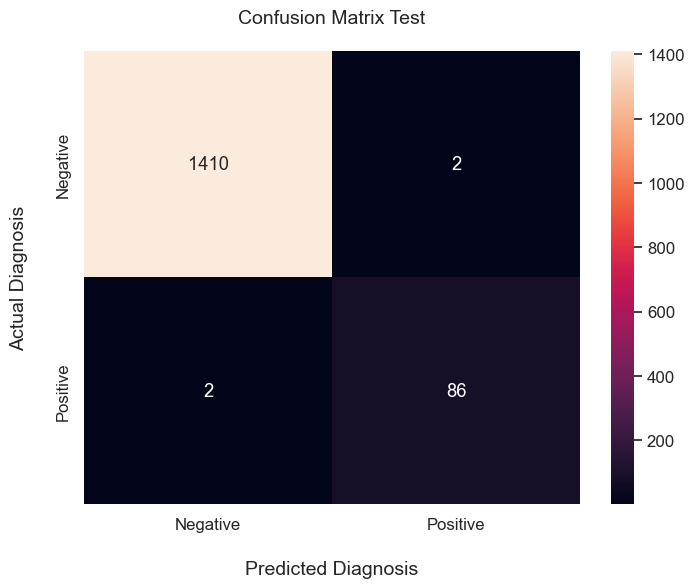

recall_score: 0.98
precision_score: 0.98


In [4]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix Test", fontsize=14, pad=20)
plt.show()

print("recall_score: %.2f" % recall_score(y_test, y_pred))
print("precision_score: %.2f" % precision_score(y_test, y_pred))
